<a href="https://colab.research.google.com/github/Josemari08sf/IntroductiontoPINN_TFG/blob/main/TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue"> Introducción a las redes neuronales físicamente informadas - Apartado práctico. </font>
---



> IMPORTANTE: El presente proyecto se ejecuta en una GPU, a la cual se accede de forma remota, dada la alta dimensión del problema, así como el tiempo de ejecución y espacio en memoria que ello requiere.



En primer lugar, se importan las librerías que serán empleadas a lo largo del presente proyecto. Además de `numpy` y `matplotlib`, la librería principal de *Python* a emplear será `DeepXde`, que implementa numerosas herramientas para la construcción y uso de PINNs. Cabe resaltar que esta última requiere de su instalación previa en el entorno de trabajo de *Python* empleado.

> Para más información acerca de la librería `DeepXde` consúltese su [documentación](https://deepxde.readthedocs.io/en/latest/).

In [1]:
import numpy as np                               # Librería de cálculo numérico.
import matplotlib.pyplot as plt                  # Librería de gráficos.
from matplotlib.animation import FuncAnimation   # Función para gráficas animadas.
from pandas import DataFrame                     # Función para el agrupamiento de datos en tablas.
from google.colab import data_table              # Función para el agrupamiento de datos en tablas dinámicas.
from IPython import display                      # Función para mostrar gráficos en el propio entorno de trabajo.
from itertools import product                    # Librería de herramientas para bucles.

!pip install deepxde                # Es necesario instalar la librería previamente.
import deepxde as dde               # Librería de PINNs.
#import tensorflow as tf            # Librería de redes neuronales.

#print("Version de TensorFlow: ", tf.__version__)       # Comprobamos la versión de TensorFlow
#print("GPU disponible: ", tf.test.is_gpu_available())  # Comprobamos que el programa se halla conectado a una GPU.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 14.5 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


## <font color="green"> Problemas directo. Ecuación de ondas unidimensional. </font>

Considérese el dominio espacial $\Omega = (x_0, x_1) \subseteq \mathbb{R}$ y el dominio temporal $T = (t_0, t_1) \subseteq \mathbb{R}$, siendo $x_0, x_1, t_0, t_1 \in \mathbb{R}$ tales que $x_0 < x_1$ y $t_0 < t_1$. Se plantea entonces el problema de encontrar una aplicación $u : \Omega \times T \to \mathbb{R}$ solución del sistema:

$$\left\{
  \begin{array} \
    u_{tt} - c^2 \, \Delta u = f \quad \qquad (x, t) \in \Omega \times T, \\
    u(x, t_0) = g(x) \quad \qquad \qquad x \in \Omega, \\
    u_t(x, t_0) = h(x) \ \ \qquad \qquad x \in \Omega, \\
    u(x_0, t) = \iota(t) \, \ \quad \qquad \qquad t \in T, \\
    u_x(x_1, t) = \kappa(t) \, \ \ \qquad \qquad t \in T,
  \end{array}
\right.$$

donde $c \in \mathbb{R}^+$; $f : \Omega \times T \to \mathbb{R}$; $g, h : \Omega \to \mathbb{R}$; $\iota, \kappa : T \to \mathbb{R}$; y $\Delta$ denota el operador laplaciano sobre la(s) variable(s) del dominio espacial (una en este caso).

Para $f \equiv 0$ la EDP es conocida como *ecuación de ondas unidimensional* ($\dim \Omega = 1$), siendo entonces $c \in \mathbb{R}^+$ un parámetro relacionado con la velocidad de desplazamiento de la onda en el medio elástico; considerado constante por simplicidad.

Para el presente ejemplo, sean $x_0 = 0 = t_0$, $x_1 = 1 = t_1$, $\mu \in \mathbb{R}$, $g(x) = \mu \cos \left( 2 \pi x \right)$, $h(x) = 0$, $\iota(t) = \mu \cos(2 \pi c t)$ y $\kappa(t) = 0$; para cada $x \in \Omega$ y $t \in T$. Se plantea entonces la resolución del **problema directo** que resulta de considerar $c = 1$ y $\mu = 0.9$.

La solución exacta, obtenida a partir de la fórmula de D'Alembert, del problema planteado es:

$$u(x, t) = \frac{1}{2} \left[ g(x + ct) + g(x - ct) \right] = \mu \cos(2 \pi x) \cos(2 \pi c t). $$

Resulta sencillo comprobar que esta solución verifica las condiciones de contorno impuestas:

$$u(0, t) = \mu \cos(2 \pi \cdot 0) \cos(2 \pi c t) = \mu \cos (2 \pi c t).$$

$$u_x(1, t) = - 2 \pi \mu \sin(2 \pi \cdot 1) \cos(2 \pi c t) = 0.$$

A continuación, se definen, del modo indicado, las aplicaciones y parámetros a considerar en el *presente ejemplo*.

In [51]:
# PARÁMETROS Y APLICACIONES DEL PROBLEMA.

# Parámetros:
T = [0, 1]          # Dominio temporal.
X = [0, 1]          # Dominio espacial.
c = 1               # Parámetro de velocidad de la onda en el medio.
mu = 0.9            # Constante de las condiciones del problema.

# Aplicaciones:

# Residuo de la EDP.
def residuo_edp(x, u):
# Ayuda de la función.
  '''
  Determina el residuo de la predicción dada por la red respecto de la EDP
  considerada.

  INPUTS:
    -> X: (list) Datos de entrada introducidos como una matriz cuyas columnas
          se corresponden con cada una de las coordenadas del dominio
          espaciotemporal del problema. En particular, considera la
          **última coordenada** (última columna en la matriz: x[:, -1]) como la que
          corresponde con la variable temporal.
    -> u: (func) Función incógnita del problema.

  OUTPUTS:
    -> Residuo respecto de la EDP (r_F(x,u)).
  '''

  # Cómputo de las derivadas parciales que figuran en la expresión de la EDP.
  du_tt = dde.grad.hessian(u, x, i=1, j=1)
  du_xx = dde.grad.hessian(u, x, i=0, j=0)

  return du_tt - (c**2)*du_xx

# Aplicaciones de las condiciones iniciales.
def func_init_pos(x):
  return mu*np.cos(2*np.pi*x[:,0:1])

def func_init_vel(x):
  return 0.0

# Aplicaciones de las condiciones de contorno.
def func_dirichlet(x):
  return mu*np.cos(2*np.pi*c*x[:,1:])

def func_neumann(x):
  return 0.0

# Frontera topológica de la condición de Dirichlet.
def boundary_dirichlet(x, on_boundary):
  is_on_boundary_D = (
      on_boundary and np.isclose(x[0], X[0])
  )
  return is_on_boundary_D

# Frontera topológica de la condición de Neumann.
def boundary_Neumann(x, on_boundary):
  is_on_boundary_N = (
      on_boundary and np.isclose(x[0], X[1])
  )
  return is_on_boundary_N

# Frontera topológica de la condición inicial.
def boundary_initial(x, on_initial):
  is_on_boundary = (
      on_initial
      and np.isclose(x[1], T[0])
      and not np.isclose(x[0], X[0])
      and not np.isclose(x[0], X[1])
  )
  return is_on_boundary

# Solución exacta
def func_exact(x):
  return mu*np.cos(2*np.pi*x[:, 0:1])*np.cos(2*np.pi*c*x[:, 1:])
 #return 0.5*(func_init_pos(x[:, 0:1] + c*t) + func_init_vel(x[:, 0:1] - c*t))

Asimismo, se fija el número de puntos de colocación a considerar para la EDP y las condiciones iniciales y de contorno.

In [52]:
num_coloc_inside = 200
num_coloc_boundary = 100
#num_coloc_initial = 25
number_test = num_coloc_inside

Lo anterior permite definir el dominio computacionalmente (gracias al correspondiente módulo de geometría del paquete `DeepXde`) y las condiciones iniciales y de contorno del problema.

In [53]:
# Dominio del problema.
geom = dde.geometry.Rectangle(xmin=[X[0], T[0]], xmax=[X[1], T[1]])

# Condiciones iniciales y de contorno.
bc_izda = dde.DirichletBC(geom, func_dirichlet, boundary_dirichlet)
bc_dcha = dde.NeumannBC(geom, func_neumann, boundary_Neumann)
ic_pos = dde.DirichletBC(geom, func_init_pos, boundary_initial)
ic_vel = dde.NeumannBC(geom, func_init_vel, boundary_initial)

# Agrupación de todos los datos acerca del problema.
data = dde.data.TimePDE(
    geom,
    residuo_edp,
    [bc_izda, bc_dcha, ic_pos, ic_vel],
    num_domain=num_coloc_inside,
    num_boundary=num_coloc_boundary,
    num_test = number_test,
    solution = func_exact)

In [54]:
# Se muestra el conjunto de datos de entrenamiento.

#print("El conjunto de datos de entrenamiento es: \n {}".format(data.train_x_all.T))

print("El conjunto de datos de entrenamiento es:")
datos_entrenamiento = np.array([data.train_x_all.T[0], data.train_x_all.T[1]]).T
tabladatos_entrenamiento = DataFrame(datos_entrenamiento, columns = ["$x_k$", "$t_k$"])
data_table.DataTable(tabladatos_entrenamiento, include_index=True, num_rows_per_page=10)

El conjunto de datos de entrenamiento es:


,$x_k$,$t_k$
0,1.000000,1.000000
1,0.500000,0.000000
2,0.500000,1.000000
3,1.000000,0.500000
4,0.000000,0.500000
...,...,...
295,0.136719,0.975124
296,0.636719,0.980099
297,0.386719,0.985075
298,0.886719,0.990050


In [55]:
# Se muestra el conjunto de datos de test.

#print("El conjunto de datos de test es: \n {}".format(data.test_x.T))

print("El conjunto de datos de test es:")
datos_test = np.array([data.test_x.T[0], data.test_x.T[1]]).T
tabladatos_test = DataFrame(datos_test, columns = ["$x_k$", "$t_k$"])
data_table.DataTable(tabladatos_test, include_index=True, num_rows_per_page=10)

El conjunto de datos de test es:


,$x_k$,$t_k$
0,0.0000,0.5000
1,0.0000,0.7500
2,0.0000,0.2500
3,0.0000,0.8750
4,0.0000,0.3750
...,...,...
320,0.9375,0.6875
321,0.9375,0.7500
322,0.9375,0.8125
323,0.9375,0.8750


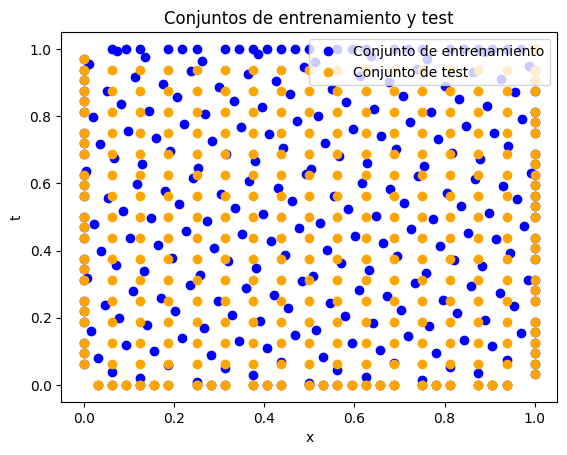

In [56]:
# Gráfico de los conjuntos de entrenamiento y test
fig, ax = plt.subplots()

ax.plot(data.train_x_all.T[0], data.train_x_all.T[1], "o", color = "blue", label="Conjunto de entrenamiento")
#ax.plot(validating_set.T[0], validating_set.T[1], "ro", label="Conjunto de validación")
ax.plot(data.test_x.T[0], data.test_x.T[1], "o", color = "orange", label="Conjunto de test")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Conjuntos de entrenamiento y test")
ax.legend(loc = "upper right")
plt.show()

Seguidamente se establecen los hiperparámetros de la PINN a construir.

In [57]:
capas = [2] + [50] * 4 + [1]       # 2 elementos en la capa de entrada, 4 capas ocultas de 50 neuronas cada una y una quinta con una sola neurona (capa de salida con un único elemento).
func_activacion = "tanh"           # Función de activación "tanh".
learning_rate = 1e-3               # Tasa de aprendizaje.
iters = 8000                       # Número de iteraciones del método de optimización.
tamanio_lotes = 500                # Tamaño de los "lotes" usados en el entrenamiento.
initializer = "Glorot uniform"     # Inicializador de pesos (de acuerdo a una distribución de Glorot).

Lo introducido hasta el momento ya permite construir el modelo de PINN a emplear para aproximar la solución del problema.

In [58]:
# Construcción de la red neuronal prealimentada (FFNN) que constituye la PINN.
net = dde.maps.FNN(capas, func_activacion, initializer)

# Definición del modelo completo.
model = dde.Model(data, net)

Finalmente, se entrena la red implementando sobre el modelo una cierta función de pérdida y algún método de optimización. En este caso, se considerará como función de pérdida, como resulta usual, el error cuadrático medio (MSE); mientras que en lo que respecta al método de optimización, para reducir los errores de entrenamiento y de generalización, se realizará un doble entrenamiento de la red: primero con el *método Adam* y, seguidamente, con el *método L-BFGS*.

In [59]:
# Primer entrenamiento empleando el método Adam.
model.compile("adam", lr=learning_rate, loss='MSE')#, loss_weights=tasas_fiab)
loss_history, train_state = model.train(iterations=iters, batch_size = tamanio_lotes)

# Segundo entrenamiento empleando el método L-BFGS.
model.compile("L-BFGS", loss='MSE')#, loss_weights=tasas_fib)
loss_history, train_state = model.train(batch_size = tamanio_lotes)

Compiling model...
Building feed-forward neural network...
'build' took 0.086094 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.940585 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.17e-03, 3.96e-01, 1.45e-02, 4.20e-01, 3.61e-03]    [2.14e-03, 3.96e-01, 1.45e-02, 4.20e-01, 3.61e-03]    []  
1000      [4.41e-03, 2.61e-03, 2.09e-03, 1.48e-03, 2.51e-03]    [5.86e-03, 2.61e-03, 2.09e-03, 1.48e-03, 2.51e-03]    []  
2000      [3.03e-03, 9.81e-04, 6.75e-04, 5.91e-04, 4.10e-04]    [2.88e-03, 9.81e-04, 6.75e-04, 5.91e-04, 4.10e-04]    []  
3000      [8.50e-04, 8.27e-04, 2.24e-04, 3.41e-04, 2.16e-04]    [1.09e-03, 8.27e-04, 2.24e-04, 3.41e-04, 2.16e-04]    []  
4000      [1.11e-03, 7.73e-04, 2.11e-04, 3.42e-04, 2.87e-04]    [1.54e-03, 7.73e-04, 2.11e-04, 3.42e-04, 2.87e-04]    []  
5000      [5.23e-04, 6.71e-04, 1.39e-04, 2.10e-04, 7.22e-05]    [5.68e-04, 6.71e-04, 1.39e-04, 2.10e-04, 7.22e-05]    []  
6000      [8.80e-03, 7.62e-04, 2.18e-03, 2.61e-04, 7.00e-05]    [6.34e-03, 7.62e-04, 2

Se imprimen las gráficas de los errores de entrenamiento ("train loss") y de generalización o testeo ("test loss").

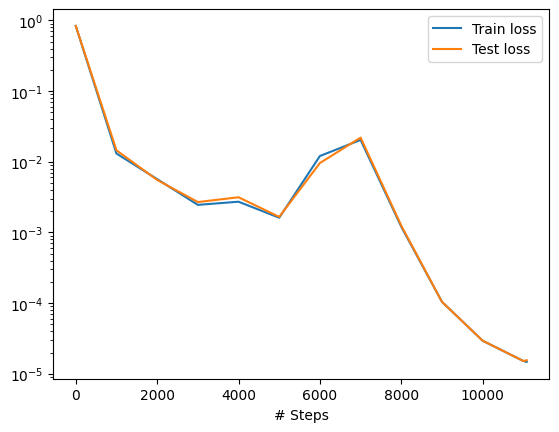

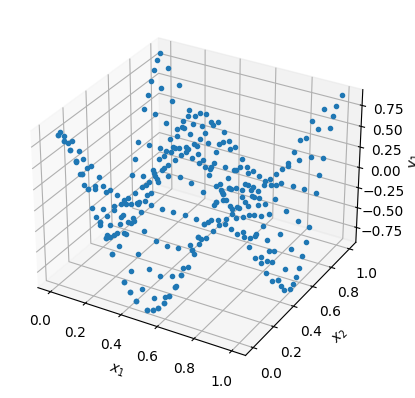

In [60]:
# Gráficas de los errores de entrenamiento y generalización.
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

Con el modelo entrenado, pueden entonces realizarse predicciones sobre la solución del problema. Se presentan a continuación algunos gráficos que permiten apreciar las predicciones realizadas por la PINN para algunos datos de entrada elegidos uniformemente sobre $\Omega \times T$, además de su comparación con la solución exacta (conocida en este caso).

Establézcase primero un cierto mallado uniforme sobre el dominio del problema $\Omega \times T$.

In [61]:
# Mallado uniforme sobre el dominio espaciotemporal.
n_ptos_x = 100                        # Número de puntos a considerar en el eje espacial.
n_ptos_t = 100                        # Número de puntos a considerar en el eje temporal.
xx=np.linspace(X[0],X[1],n_ptos_x)    # Partición del dominio espacial.
tt=np.linspace(T[0],T[1],n_ptos_t)    # Partición del dominio temporal.

# Se extraen los elementos del producto cartesiano que conforma el mallado, en este caso ordenando primero según tt y luego según xx.
Xx, Tt = np.meshgrid(xx, tt)

El siguiente gráfico muestra la predicción realizada por la PINN para un cierto número de instantes de tiempo prefijados y contenidos en el mallado anterior.

Instante: 0.0 	
[Mín(u_θ), máx(u_θ)] = [-0.8965818881988525, 0.8991235494613647]


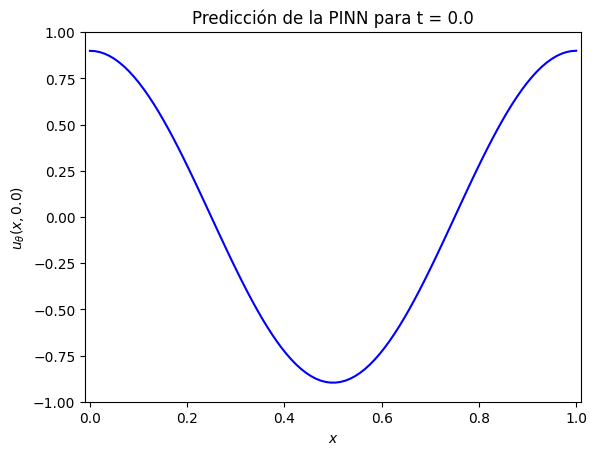

Instante: 0.10101010101010102 	
[Mín(u_θ), máx(u_θ)] = [-0.7243601083755493, 0.7254214286804199]


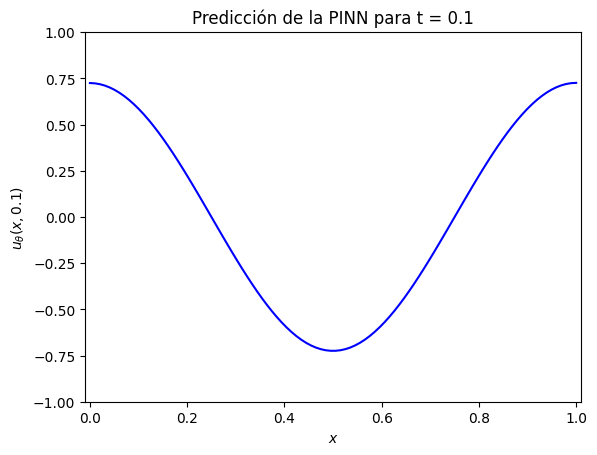

Instante: 0.20202020202020204 	
[Mín(u_θ), máx(u_θ)] = [-0.26960471272468567, 0.26844510436058044]


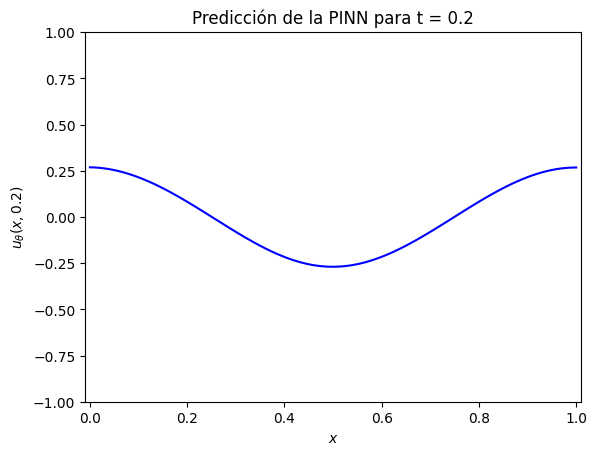

Instante: 0.30303030303030304 	
[Mín(u_θ), máx(u_θ)] = [-0.29663869738578796, 0.29411783814430237]


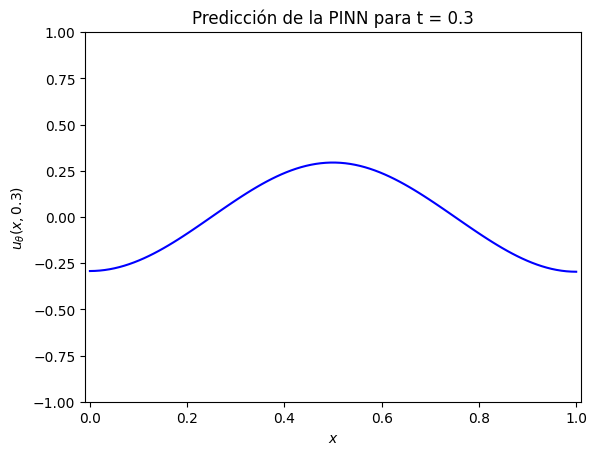

Instante: 0.4040404040404041 	
[Mín(u_θ), máx(u_θ)] = [-0.7411638498306274, 0.741579532623291]


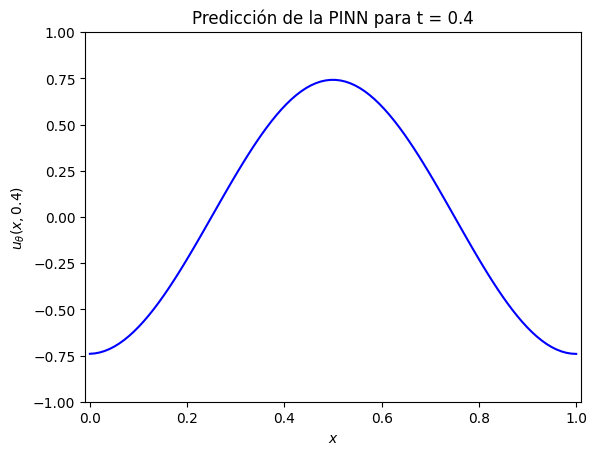

Instante: 0.5050505050505051 	
[Mín(u_θ), máx(u_θ)] = [-0.9013141393661499, 0.8980629444122314]


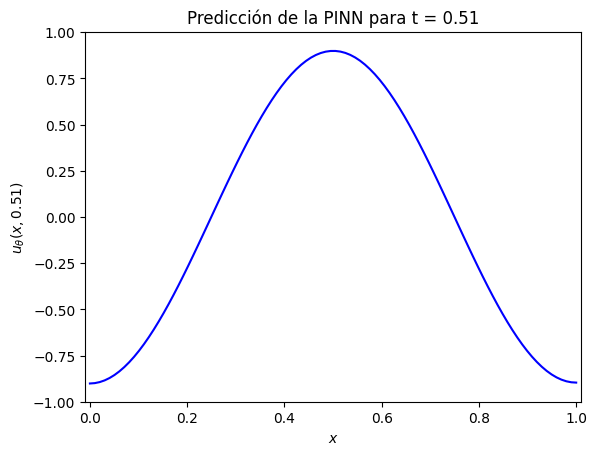

Instante: 0.6060606060606061 	
[Mín(u_θ), máx(u_θ)] = [-0.7091347575187683, 0.7070431709289551]


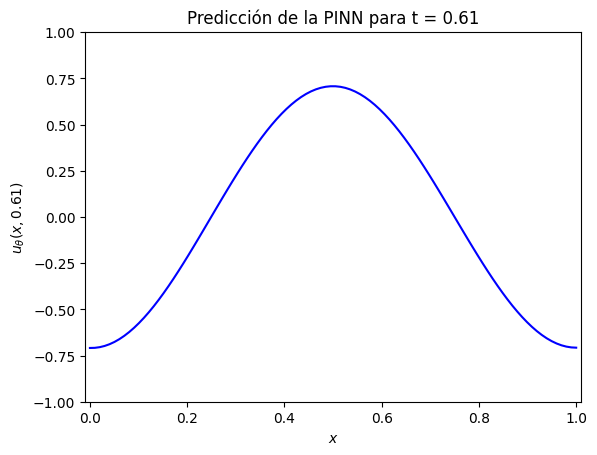

Instante: 0.7070707070707072 	
[Mín(u_θ), máx(u_θ)] = [-0.24257701635360718, 0.24176493287086487]


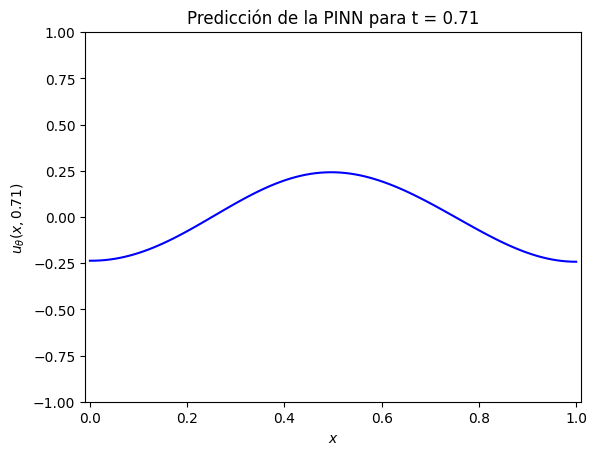

Instante: 0.8080808080808082 	
[Mín(u_θ), máx(u_θ)] = [-0.3192491829395294, 0.3226574957370758]


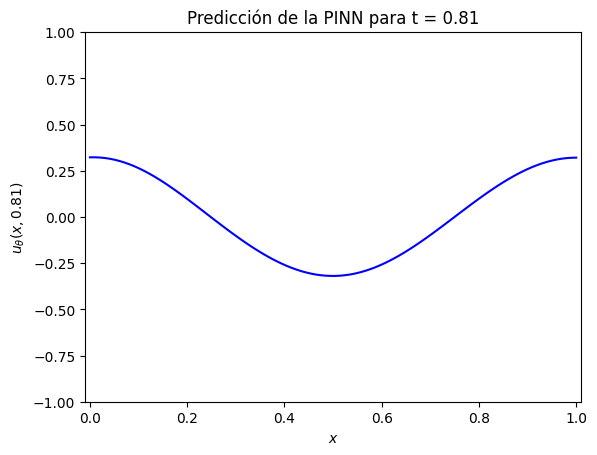

Instante: 0.9090909090909092 	
[Mín(u_θ), máx(u_θ)] = [-0.7566063404083252, 0.7576963901519775]


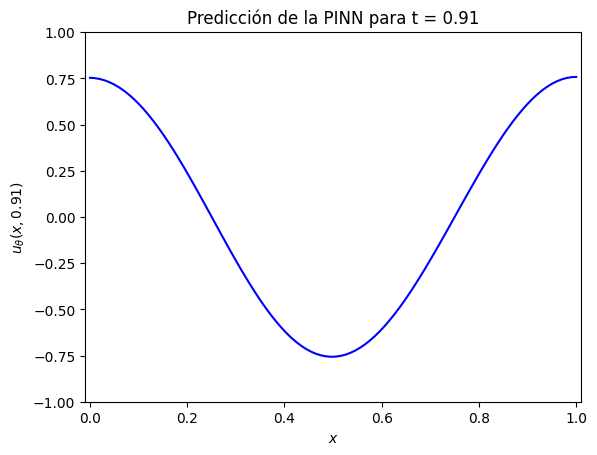

In [62]:
# Gráfico de la predicción de la PINN por instantes de tiempo.

num_inst = 10                                                            # Número de instantes de tiempo considerados.
t_list = [tt[int(inst*(len(tt)/num_inst))] for inst in range(num_inst)]  # Instantes de tiempo considerados dentro del mallado anterior.

for t in t_list:
  print("Instante:", t, "\t")           # Escritura en pantalla.

  # Restricción del mallado correspondiente al instante considerado.
  x_repre, t_repre = np.meshgrid(xx, t)
  XT_list = np.vstack((x_repre.ravel(), t_repre.ravel())).T

  # Predicción realizada por la PINN.
  U = model.predict(XT_list).T
  print(f"[Mín(u_θ), máx(u_θ)] = [{min(U[0])}, {max(U[0])}]")        # Escritura en pantalla de los valores mínimo y máximo de la predicción.

  # Representación gráfica.
  fig, ax = plt.subplots()
  ax.plot(x_repre[0],U[0], color="blue")

  # Instrucciones decorativas del gráfico.
  ax.set_title("Predicción de la PINN para t = "+str(round(t,2)))
  ax.set_xlabel("$x$")
  ax.set_ylabel("$u_θ(x,$"+str(round(t,2))+")")
  ax.set_xlim(-0.01,1.01)
  ax.set_ylim(-1.0,1.0)

  plt.show()                            # Se muestra el gráfico.

Gracias al módulo `matplotlib.animate`, es posible representar la predicción sobre el mallado completo por instantes en forma de animación.

In [63]:
# Animación de la predicción de la PINN sobre el mallado uniforme.

XT_list = []
U = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado.
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos.

# Representación gráfica.
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico.
ax.set_title("Predicción de la PINN")
ax.set_xlabel("$x$")
ax.set_ylabel("$u_θ(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-1.0,1.0)

line, = ax.plot(Xx[0],U[0][0], color="blue")

def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(U[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo.
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación.
display.display(html)
plt.close()

#anim.save('PINNEj1prediccion.mp4', fps=30)     # Se almacena la animación.

Del mismo modo, puede representarse la solución exacta del problema.

In [64]:
# Animación de la solución exacta sobre el mallado uniforme.

XT_list = []
sol_exact = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado.
  sol_exact.append(func_exact(XT_list[i]).T)   # Solución sobre los puntos.

# Representación gráfica.
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico.
ax.set_title("Solución exacta")
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-1.0,1.0)

line, = ax.plot(Xx[0],sol_exact[0][0], color="green")

def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(sol_exact[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo.
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación.
display.display(html)
plt.close()

#anim.save('PINNEj1solexacta.mp4', fps=30)     # Se almacena la animación.

El conocimiento de la solución exacta, permite la comparación entre la misma y la predicción de la PINN.

In [65]:
# Animación de la comparación entre la predicción de la PINN y la solución exacta sobre el mallado uniforme.

XT_list = []
U = []
sol_exact = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado.
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos.
  sol_exact.append(func_exact(XT_list[i]).T)   # Solución sobre los puntos.

# Representación gráfica.
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico.
ax.set_title("Comparación entre la predicción de la PINN y la solución exacta.")
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-1.0,1.0)

line1, = ax.plot(Xx[0],U[0][0], color="blue")
line2, = ax.plot(Xx[0],sol_exact[0][0], color="green")

def animate_func(i):
  line1.set_xdata(Xx[i])
  line1.set_ydata(U[i][0])
  line2.set_xdata(Xx[i])
  line2.set_ydata(sol_exact[i][0])
  return line1, line2

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo.
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación.
display.display(html)
plt.close()

#anim.save('PINNEj1comparacion.mp4', fps=30)     # Se almacena la animación.

Dicha comparación puede realizarse también por medio del cálculo del error entre la predicción y la solución conocida. A continuación se mide y representa este error en norma $L^2(\Omega)$ por cada instante de tiempo.

In [66]:
# Cálculo del error en norma L^2(\Omega)

from scipy.integrate import quad

error = []
for t in tt:
  error.append(quad(lambda x: (model.predict([[x,t]])[0,0] - func_exact(np.array([[x,t]]))[0,0])**2,X[0],X[1]))

error = np.array(error).T

errorL2 = error[0]
error_aprox_integr = error[1]

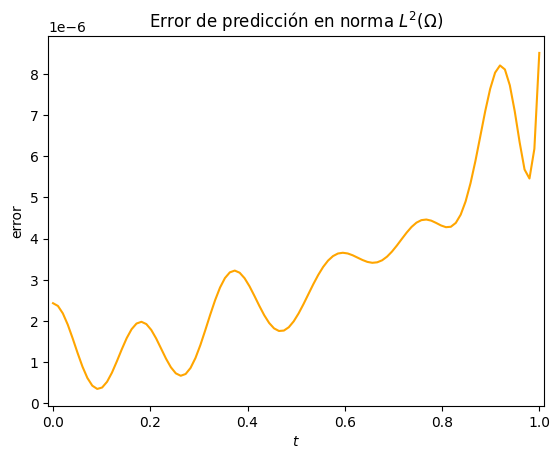

In [67]:
# Representación gráfica del error en norma L^2(\Omega)
fig, ax = plt.subplots()
ax.plot(tt,errorL2, color="orange")

# Instrucciones decorativas del gráfico.
ax.set_title("Error de predicción en norma $L^2(\Omega)$")
ax.set_xlabel("$t$")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)
#ax.set_ylim(-1e-8,7.5e-6)

plt.show()                            # Se muestra el gráfico.

En el cálculo del error en norma $L^2(\Omega)$ se ha realizado la correspondiente integral sobre $\Omega$ empleando la función `quad` del módulo `scipy.integrate`, la cual implementa de forma sofisticada fórmulas de cuadratura compuestas y adaptativas (véase la [documentación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) para más información). Esta función, devuelve además una estimación del error absoluto con respecto a la integral exacta, el cual se representa a continuación.

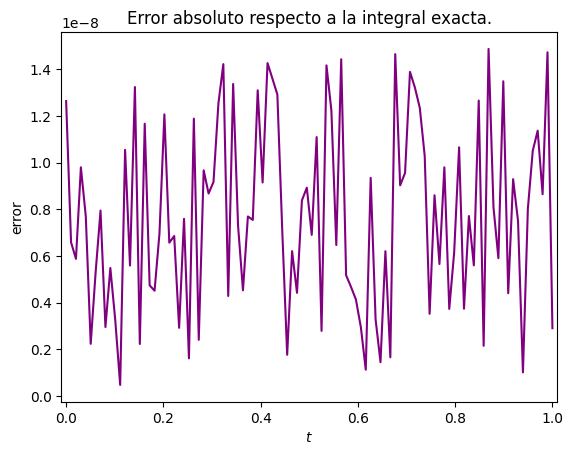

In [68]:
# Representación gráfica del error de cuadratura
fig, ax = plt.subplots()
ax.plot(tt,error_aprox_integr, color="purple")

# Instrucciones decorativas del gráfico.
ax.set_title("Error absoluto respecto a la integral exacta.")
ax.set_xlabel("$t$")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)
#ax.set_ylim(-1e-8,7.5e-6)

plt.show()                            # Se muestra el gráfico.

## <font color="green"> Problema inverso. Ecuación del calor unidimensional. </font>

Considérense el dominio espacial $\Omega = (x_0, x_1) \subseteq \mathbb{R}$ y el dominio temporal $T = (t_0, t_1) \subseteq \mathbb{R}$, siendo $x_0, x_1, t_0, t_1 \in \mathbb{R}$ tales que $x_0 < x_1$ y $t_0 < t_1$. Se plantea entonces el problema de encontrar una aplicación $u : \Omega \times T \to \mathbb{R}$ solución del sistema:

$$\left\{
  \begin{array} \
    u_t - \alpha \, \Delta u = f \quad \qquad (x, t) \in \Omega \times T, \\
    u = g \, \ \ \ \qquad \qquad \qquad (x, t) \in \partial\Omega \times T, \\
    u(x, t_0) = h(x) \, \ \qquad \qquad x \in \Omega,
  \end{array}
\right.$$

donde $\alpha \in \mathbb{R}^+$, $f : \Omega \times T \to \mathbb{R}$, $g : \partial \Omega \times T \to \mathbb{R}$, $h : \Omega \to \mathbb{R}$, y $\Delta$ denota el operador laplaciano sobre la(s) variable(s) del dominio espacial (una en este caso).

Para $f \equiv 0$ la EDP es conocida como *ecuación del calor unidimensional* ($\dim \Omega = 1$) sin fuente de energía externa, siendo entonces $\alpha \in \mathbb{R}^+$ referido como *difusividad térmica del material*, el cual será considerado constante por simplicidad.

Para el presente ejemplo, sean $x_0 = 0 = t_0$, $x_1 = 1$, $t_1 = 0.2$, $g \equiv 0$ y $h(x) = 4 x (1 - x)$; para cada $x \in \Omega$. Se plantea entonces la resolución del \emph{problema inverso} de estimar el valor del parámetro $\alpha$. Para validar la bondad de los resultados, se considerará que el problema refleja la realidad para $\alpha = 1.0$.

La solución exacta, obtenida mediante el *método de separación de variables*, del problema planteado es:

$$u(x, t) = \displaystyle \sum_{n = 1}^{\infty} \, C_n e^{- \alpha \pi^2 n^2 t} \, \sin \left( n \pi x\right),$$

donde $\displaystyle C_n = 2 \int_{0}^{1} \, h(x) \, \sin \left( n \pi x \right) \, \mathrm{d}x = 8 \int_{0}^{1} \, x (1 - x) \, \sin \left( n \pi x \right) \, \mathrm{d}x = \frac{16}{n^3\pi^3} \left[ 1 - (-1)^n \right] $.

Determinando la integral anterior (por ejemplo, por partes), se observa que para todo $k \in \mathbb{N}$ es $C_{2k} = 0$ y $C_{2k-1} = \frac{32}{(2k-1)^3\pi^3}$.

En definitiva, es:

$$u(x, t) = \displaystyle \sum_{k = 1}^{\infty} \,  \frac{32}{(2k-1)^3\pi^3} e^{- \alpha \pi^2 (2k-1)^2 t} \, \sin \left( (2k-1) \pi x\right).$$

A continuación, se definen, del modo indicado, las aplicaciones y parámetros a considerar en el *presente ejemplo*.

In [22]:
# PARÁMETROS Y APLICACIONES DEL PROBLEMA.

# Parámetros:
T = [0, 0.2]         # Dominio temporal.
X = [0, 1]           # Dominio espacial.

# Parámetro físico (alpha) a extraer del problema y datos observados.
alpha_sol = 1.0                               # Valor real del parámetro.
param_inicialization = 0.2                    # Valor de inicialización del parámetro desconocido.
alpha = dde.Variable(param_inicialization)    # Declaración del parámetro como desconocido e inicialización.


# Aplicaciones:

# Residuo de la EDP.
def residuo_edp(x, u):
# Ayuda de la función.
  '''
  Determina el residuo de la predicción dada por la red respecto de la EDP
  considerada.

  INPUTS:
    -> X: (list) Datos de entrada introducidos como una matriz cuyas columnas
          se corresponden con cada una de las coordenadas del dominio
          espaciotemporal del problema. En particular, considera la
          **última coordenada** (última columna en la matriz: x[:, -1]) como la que
          corresponde con la variable temporal.
    -> u: (func) Función incógnita del problema.

  OUTPUTS:
    -> Residuo respecto de la EDP (r_F(x,u)).
  '''

  # Cómputo de las derivadas parciales que figuran en la expresión de la EDP.
  du_t = dde.grad.jacobian(u, x, i=0, j=1)
  du_xx = dde.grad.hessian(u, x, i=0, j=0)

  return du_t - alpha*du_xx

# Aplicación de la condición inicial.
def func_init(x):
  return 4*x[:,0:1]*(1 - x[:,0:1])

# Aplicación de las condiciones de contorno.
def func_dirichlet(x):
  return 0.0

# Frontera topológica de las condiciones de Dirichlet.
def boundary_dirichlet_izda(x, on_boundary):
  is_on_boundary_D = (
      on_boundary and np.isclose(x[0], X[0])
  )
  return is_on_boundary_D

def boundary_dirichlet_dcha(x, on_boundary):
  is_on_boundary_D = (
      on_boundary and np.isclose(x[0], X[1])
  )
  return is_on_boundary_D

# Frontera topológica de la condición inicial.
def boundary_initial(x, on_initial):
  is_on_boundary = (
      on_initial
      and np.isclose(x[1], T[0])
      and not np.isclose(x[0], X[0])
      and not np.isclose(x[0], X[1])
  )
  return is_on_boundary

# Solución exacta truncada.
def func_exact(x):
  trunc_num = 10
  suma = 0
  for k in range(1,trunc_num+1):
    suma = suma + (32/(((2*k-1)**3)*(np.pi**3)))*np.exp(-alpha_sol*(np.pi**2)*((2*k-1)**2)*x[:, 1:])*np.sin((2*k-1)*np.pi*x[:, 0:1])
  return suma

Asimismo, se fija el número de puntos de colocación a considerar para la EDP y las condiciones iniciales y de contorno.

In [23]:
num_coloc_inside = 200
num_coloc_boundary = 100
#num_coloc_initial = 25
number_test = num_coloc_inside

Lo anterior permite definir el dominio computacionalmente (gracias al correspondiente módulo de geometría del paquete `DeepXde`) y las condiciones iniciales y de contorno del problema. Asimismo, se incluyen un conjunto de observaciones de la solución del problema (a partir del conocimiento de la solución exacta truncada en este caso).

In [24]:
# Dominio del problema.
geom = dde.geometry.Rectangle(xmin=[X[0], T[0]], xmax=[X[1], T[1]])

# Condiciones iniciales y de contorno.
bc_izda = dde.DirichletBC(geom, func_dirichlet, boundary_dirichlet_izda)
bc_dcha = dde.DirichletBC(geom, func_dirichlet, boundary_dirichlet_dcha)
ic = dde.DirichletBC(geom, func_init, boundary_initial)

# Observaciones adicionales.
num_observ = 50
observ_x = np.vstack((np.linspace(X[0], X[1], num_observ), np.full((num_observ), T[1]))).T
observ_u = dde.icbc.PointSetBC(observ_x, func_exact(observ_x), component=0)

# Agrupación de todos los datos acerca del problema.
data = dde.data.TimePDE(
    geom,
    residuo_edp,
    [bc_izda, bc_dcha, ic, observ_u],
    anchors=observ_x,
    num_domain=num_coloc_inside,
    num_boundary=num_coloc_boundary,
    num_test = number_test,
    solution = func_exact)

In [25]:
# Se muestra el conjunto de datos de entrenamiento.

#print("El conjunto de datos de entrenamiento es: \n {}".format(data.train_x_all.T))

print("El conjunto de datos de entrenamiento es:")
datos_entrenamiento = np.array([data.train_x_all.T[0], data.train_x_all.T[1]]).T
tabladatos_entrenamiento = DataFrame(datos_entrenamiento, columns = ["$x_k$", "$t_k$"])
data_table.DataTable(tabladatos_entrenamiento, include_index=True, num_rows_per_page=10)

El conjunto de datos de entrenamiento es:


,$x_k$,$t_k$
0,0.000000,0.200000
1,0.020408,0.200000
2,0.040816,0.200000
3,0.061224,0.200000
4,0.081633,0.200000
...,...,...
345,0.136719,0.195025
346,0.636719,0.196020
347,0.386719,0.197015
348,0.886719,0.198010


In [26]:
# Se muestra el conjunto de datos de test.

#print("El conjunto de datos de test es: \n {}".format(data.test_x.T))

print("El conjunto de datos de test es:")
datos_test = np.array([data.test_x.T[0], data.test_x.T[1]]).T
tabladatos_test = DataFrame(datos_test, columns = ["$x_k$", "$t_k$"])
data_table.DataTable(tabladatos_test, include_index=True, num_rows_per_page=10)

El conjunto de datos de test es:


,$x_k$,$t_k$
0,0.000000,0.2000
1,0.000000,0.1500
2,0.000000,0.0750
3,0.000000,0.1125
4,0.000000,0.1875
...,...,...
329,0.969697,0.0750
330,0.969697,0.1000
331,0.969697,0.1250
332,0.969697,0.1500


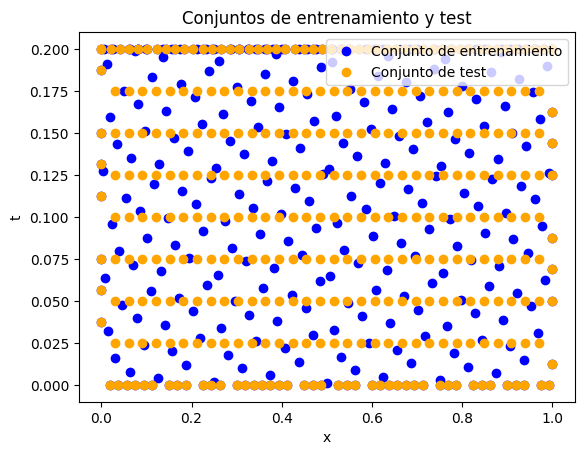

In [27]:
# Gráfico de los conjuntos de entrenamiento y test
fig, ax = plt.subplots()

ax.plot(data.train_x_all.T[0], data.train_x_all.T[1], "o", color = "blue", label="Conjunto de entrenamiento")
#ax.plot(validating_set.T[0], validating_set.T[1], "ro", label="Conjunto de validación")
ax.plot(data.test_x.T[0], data.test_x.T[1], "o", color = "orange", label="Conjunto de test")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Conjuntos de entrenamiento y test")
ax.legend(loc = "upper right")
plt.show()

Seguidamente se establecen los hiperparámetros de la PINN a construir.

In [28]:
capas = [2] + [50] * 4 + [1]       # 2 elementos en la capa de entrada, 4 capas ocultas de 50 neuronas cada una y una quinta con una sola neurona (capa de salida con un único elemento).
func_activacion = "tanh"           # Función de activación "tanh".
learning_rate = 1e-3               # Tasa de aprendizaje.
iters = 10000                      # Número de iteraciones del método de optimización.
tamanio_lotes = 500                # Tamaño de los "lotes" usados en el entrenamiento.
initializer = "Glorot uniform"     # Inicializador de pesos (de acuerdo a una distribución de Glorot).

Lo introducido hasta el momento ya permite construir el modelo de PINN a emplear para aproximar la solución del problema.

In [29]:
# Construcción de la red neuronal prealimentada (FFNN) que constituye la PINN.
net = dde.maps.FNN(capas, func_activacion, initializer)

# Definición del modelo completo.
model = dde.Model(data, net)

Finalmente, se entrena la red implementando sobre el modelo una cierta función de pérdida y algún método de optimización. En este caso, se considerará como función de pérdida, como resulta usual, el error cuadrático medio (MSE); mientras que en lo que respecta al método de optimización, para reducir los errores de entrenamiento y de generalización, se realizará un doble entrenamiento de la red: primero con el *método Adam* y, seguidamente, con el *método L-BFGS*. Durante el entrenamiento, se incluye además el parámetro a determinar $\alpha$ como "variable externa" (y se muestra el valor que se va adquiriendo de este cada $1000$ iteraciones).

In [30]:
# Primer entrenamiento empleando el método Adam.
model.compile("adam", lr=learning_rate, loss='MSE', external_trainable_variables=alpha)#, loss_weights=tasas_fiab)
variable = dde.callbacks.VariableValue(alpha, period=1000)#, filename="variables.dat")  # Mostrar el valor adquirido de alpha cada 1000 iteraciones.
loss_history, train_state = model.train(iterations=iters, batch_size = tamanio_lotes, callbacks=[variable])

# Segundo entrenamiento empleando el método L-BFGS.
model.compile("L-BFGS", loss='MSE', external_trainable_variables=alpha)#, loss_weights=tasas_fib)
variable = dde.callbacks.VariableValue(alpha, period=1000)#, filename="variables.dat")  # Mostrar el valor adquirido de alpha cada 1000 iteraciones.
loss_history, train_state = model.train(batch_size = tamanio_lotes, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.079344 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.734142 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.84e-02, 4.54e-04, 3.54e-02, 4.01e-01, 5.63e-03]    [1.82e-02, 4.54e-04, 3.54e-02, 4.01e-01, 5.63e-03]    []  
0 [2.00e-01]
1000      [9.94e-04, 6.34e-04, 2.74e-03, 1.76e-03, 7.21e-03]    [6.28e-04, 6.34e-04, 2.74e-03, 1.76e-03, 7.21e-03]    []  
1000 [6.43e-01]
2000      [1.28e-03, 1.40e-04, 1.31e-03, 8.64e-04, 2.63e-03]    [1.04e-03, 1.40e-04, 1.31e-03, 8.64e-04, 2.63e-03]    []  
2000 [7.72e-01]
3000      [4.27e-04, 1.05e-04, 4.27e-04, 4.54e-04, 9.59e-04]    [4.34e-04, 1.05e-04, 4.27e-04, 4.54e-04, 9.59e-04]    []  
3000 [8.39e-01]
4000      [3.63e-04, 7.77e-05, 1.83e-04, 3.07e-04, 3.82e-04]    [4.41e-04, 7.77e-05, 1.83e-04, 3.07e-04, 3.82e-04]    []  
4000 [8.84e-01]
5000      [1.85e-04, 5.37e-05, 1.37e-04, 3.02e-04, 1.67e-04]    [2.03e-04, 5.37e-05, 1.37e-04, 3.02e-04, 1.67e-04]    []  
5000 [9.1

Se imprimen las gráficas de los errores de entrenamiento ("train loss") y de generalización o testeo ("test loss").

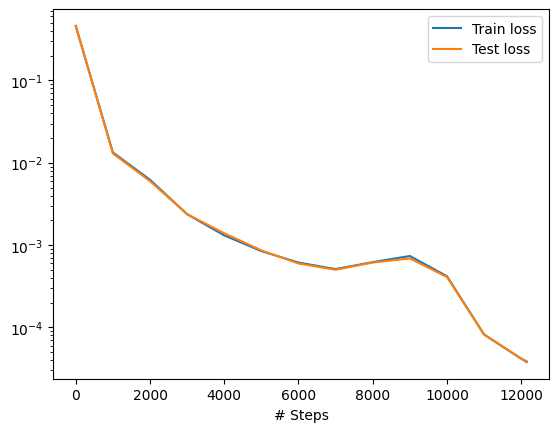

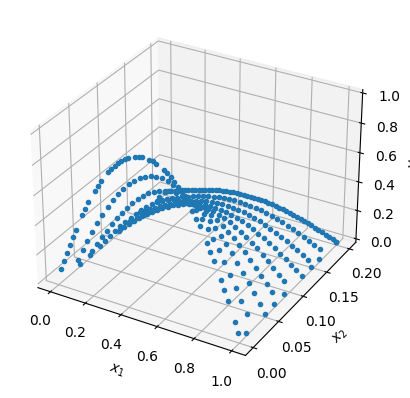

In [31]:
# Gráficas de los errores de entrenamiento y generalización.
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

Con el modelo entrenado, pueden entonces realizarse predicciones sobre la solución del problema. Se presentan a continuación algunos gráficos que permiten apreciar las predicciones realizadas por la PINN para algunos datos de entrada elegidos uniformemente sobre $\Omega \times T$, además de su comparación con la solución exacta (conocida en este caso).

Establézcase primero un cierto mallado uniforme sobre el dominio del problema $\Omega \times T$.

In [32]:
# Mallado uniforme sobre el dominio espaciotemporal.
n_ptos_x = 100                        # Número de puntos a considerar en el eje espacial.
n_ptos_t = 100                        # Número de puntos a considerar en el eje temporal.
xx=np.linspace(X[0],X[1],n_ptos_x)    # Partición del dominio espacial.
tt=np.linspace(T[0],T[1],n_ptos_t)    # Partición del dominio temporal.

# Se extraen los elementos del producto cartesiano que conforma el mallado, en este caso ordenando primero según tt y luego según xx.
Xx, Tt = np.meshgrid(xx, tt)

El siguiente gráfico muestra la predicción realizada por la PINN para un cierto número de instantes de tiempo prefijados y contenidos en el mallado anterior.

Instante: 0.0 	
[Mín(u), máx(u)] = [0.01701151579618454, 1.0014488697052002]


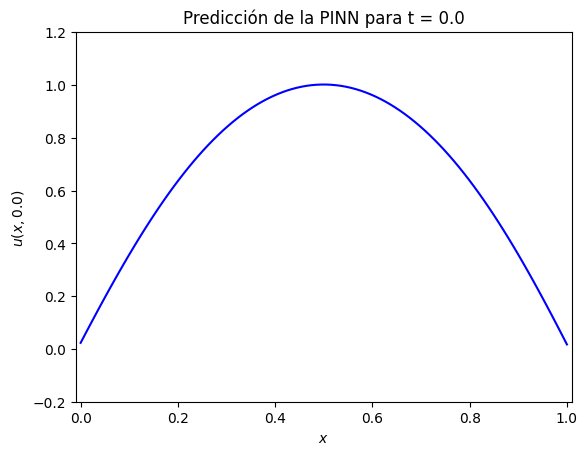

Instante: 0.0202020202020202 	
[Mín(u), máx(u)] = [-0.006285317242145538, 0.8394197225570679]


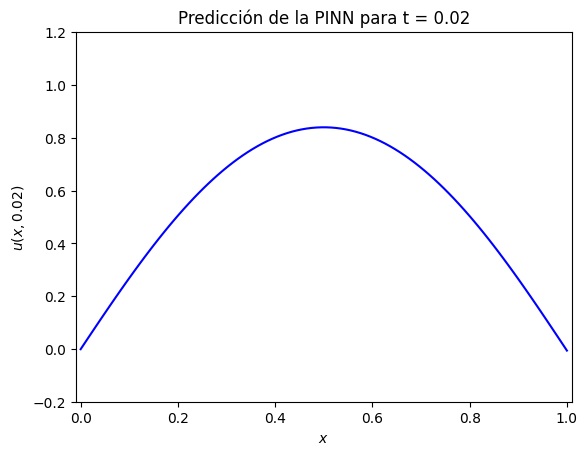

Instante: 0.0404040404040404 	
[Mín(u), máx(u)] = [-0.005665011703968048, 0.6917415857315063]


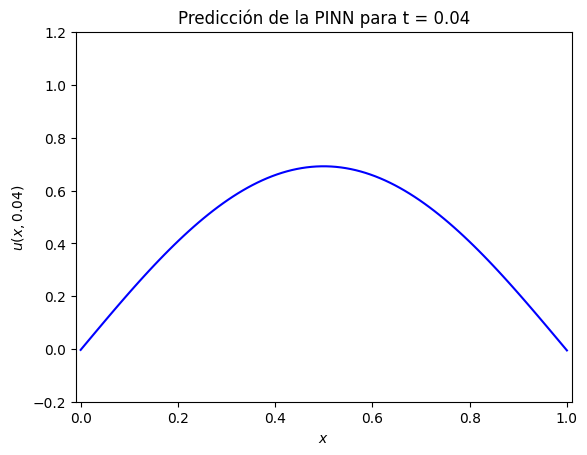

Instante: 0.06060606060606061 	
[Mín(u), máx(u)] = [-0.0014266446232795715, 0.5666093230247498]


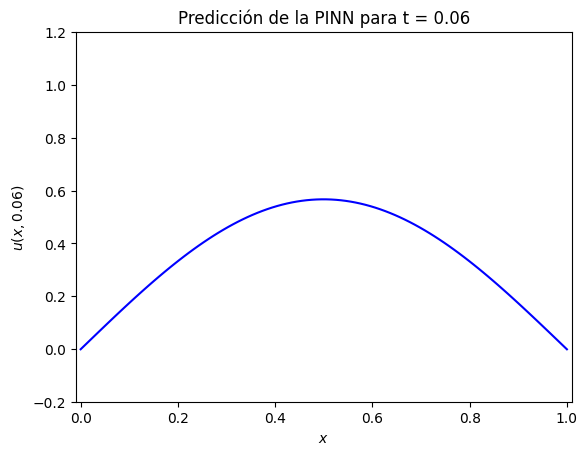

Instante: 0.0808080808080808 	
[Mín(u), máx(u)] = [0.0008946582674980164, 0.46362197399139404]


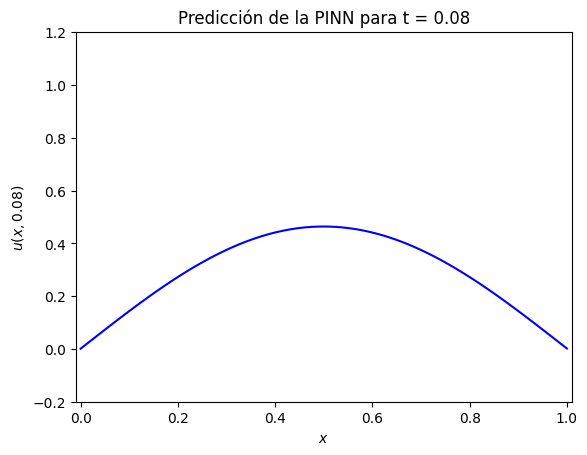

Instante: 0.10101010101010101 	
[Mín(u), máx(u)] = [0.002069227397441864, 0.3796338438987732]


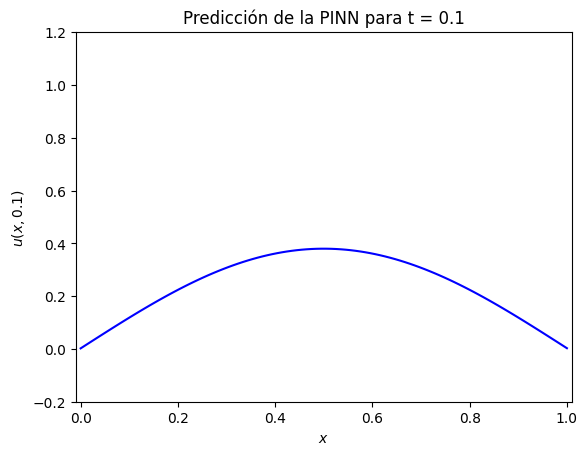

Instante: 0.12121212121212122 	
[Mín(u), máx(u)] = [0.0022560879588127136, 0.31117701530456543]


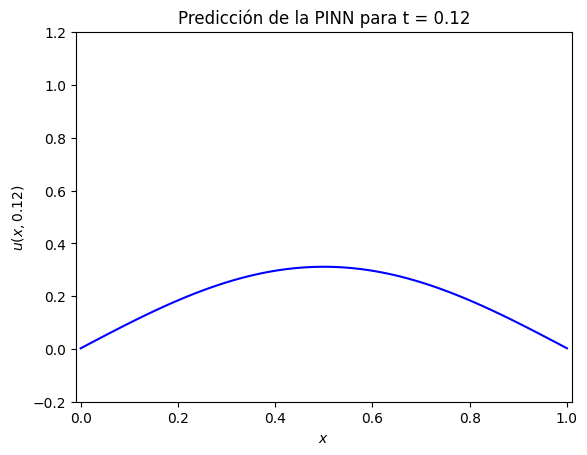

Instante: 0.1414141414141414 	
[Mín(u), máx(u)] = [0.0016843602061271667, 0.2552638053894043]


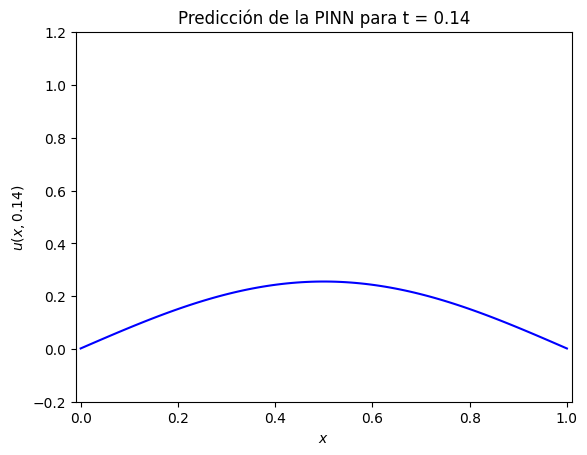

Instante: 0.1616161616161616 	
[Mín(u), máx(u)] = [0.0005875751376152039, 0.20947110652923584]


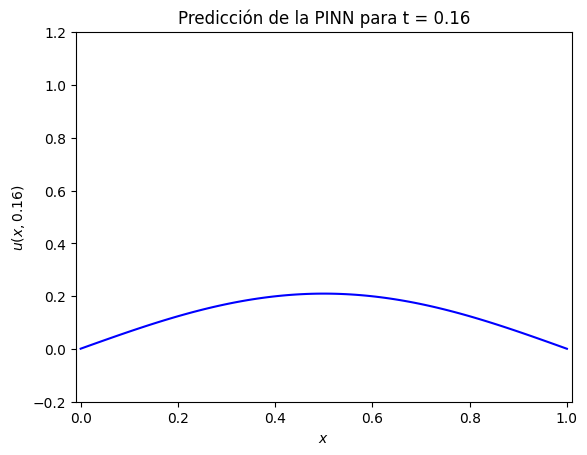

Instante: 0.18181818181818182 	
[Mín(u), máx(u)] = [-0.000501580536365509, 0.1718529462814331]


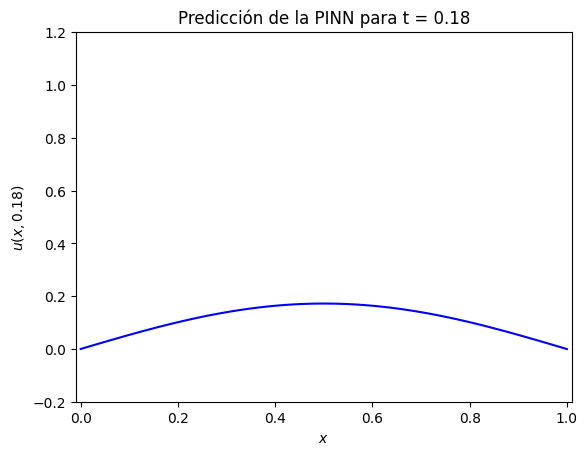

In [33]:
# Gráfico de la predicción de la PINN por instantes de tiempo.

num_inst = 10                                                            # Número de instantes de tiempo considerados.
t_list = [tt[int(inst*(len(tt)/num_inst))] for inst in range(num_inst)]  # Instantes de tiempo considerados dentro del mallado anterior.

for t in t_list:
  print("Instante:", t, "\t")           # Escritura en pantalla.

  # Restricción del mallado correspondiente al instante considerado.
  x_repre, t_repre = np.meshgrid(xx, t)
  XT_list = np.vstack((x_repre.ravel(), t_repre.ravel())).T

  # Predicción realizada por la PINN.
  U = model.predict(XT_list).T
  print(f"[Mín(u), máx(u)] = [{min(U[0])}, {max(U[0])}]")        # Escritura en pantalla de los valores mínimo y máximo de la predicción.

  # Representación gráfica.
  fig, ax = plt.subplots()
  ax.plot(x_repre[0],U[0], color="blue")

  # Instrucciones decorativas del gráfico.
  ax.set_title("Predicción de la PINN para t = "+str(round(t,2)))
  ax.set_xlabel("$x$")
  ax.set_ylabel("$u(x,$"+str(round(t,2))+")")
  ax.set_xlim(-0.01,1.01)
  ax.set_ylim(-0.2,1.2)

  plt.show()                            # Se muestra el gráfico.

Gracias al módulo `matplotlib.animate`, es posible representar la predicción sobre el mallado completo por instantes en forma de animación.

In [44]:
# Animación de la predicción de la PINN sobre el mallado uniforme.

XT_list = []
U = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado.
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos.

# Representación gráfica.
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico.
ax.set_title("Predicción de la PINN")
ax.set_xlabel("$x$")
ax.set_ylabel("$u_θ(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.2,1.2)

line, = ax.plot(Xx[0],U[0][0], color="blue")

def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(U[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo.
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación.
display.display(html)
plt.close()

#anim.save('PINNEj2prediccion.mp4', fps=30)     # Se almacena la animación.

Del mismo modo, puede representarse la solución exacta del problema.

In [45]:
# Animación de la solución exacta sobre el mallado uniforme.

sol_exact = []
for i in range(len(Xx)):
  sol_exact.append(func_exact(XT_list[i]).T)        # Predicción sobre los puntos.

# Representación gráfica.
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico.
ax.set_title("Solución exacta")
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.2,1.2)

line, = ax.plot(Xx[0],sol_exact[0][0], color="green")

def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(sol_exact[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo.
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación.
display.display(html)
plt.close()

#anim.save('PINNEj2solexacta.mp4', fps=30)     # Se almacena la animación.

El conocimiento de la solución exacta, permite la comparación entre la misma y la predicción de la PINN.

In [50]:
# Animación de la comparación entre la predicción de la PINN y la solución exacta sobre el mallado uniforme.

XT_list = []
U = []
sol_exact = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado.
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos.
  sol_exact.append(func_exact(XT_list[i]).T)   # Solución sobre los puntos.

# Representación gráfica.
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico.
ax.set_title("Comparación entre la predicción de la PINN y la solución exacta.")
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.2,1.2)

line1, = ax.plot(Xx[0],U[0][0], color="blue")
line2, = ax.plot(Xx[0],sol_exact[0][0], color="green")

def animate_func(i):
  line1.set_xdata(Xx[i])
  line1.set_ydata(U[i][0])
  line2.set_xdata(Xx[i])
  line2.set_ydata(sol_exact[i][0])
  return line1, line2

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo.
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación.
display.display(html)
plt.close()

#anim.save('PINNEj2comparacion.mp4', fps=30)     # Se almacena la animación.

Dicha comparación puede realizarse también por medio del cálculo del error entre la predicción y la solución conocida. A continuación se mide y representa este error en norma $L^2(\Omega)$ por cada instante de tiempo.

In [47]:
# Cálculo del error en norma L^2(\Omega)

from scipy.integrate import quad

error = []
for t in tt:
  error.append(quad(lambda x: (model.predict([[x,t]])[0,0] - func_exact(np.array([[x,t]]))[0,0])**2,X[0],X[1]))

error = np.array(error).T

errorL2 = error[0]
error_aprox_integr = error[1]

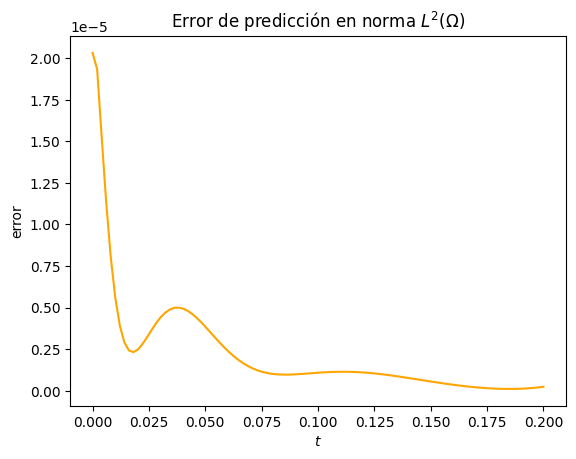

In [48]:
# Representación gráfica del error en norma L^2(\Omega)
fig, ax = plt.subplots()
ax.plot(tt,errorL2, color="orange")

# Instrucciones decorativas del gráfico.
ax.set_title("Error de predicción en norma $L^2(\Omega)$")
ax.set_xlabel("$t$")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)

plt.show()                            # Se muestra el gráfico.

En el cálculo del error en norma $L^2(\Omega)$ se ha realizado la correspondiente integral sobre $\Omega$ empleando la función `quad` del módulo `scipy.integrate`, la cual implementa de forma sofisticada fórmulas de cuadratura compuestas y adaptativas (véase la [documentación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) para más información). Esta función, devuelve además una estimación del error absoluto con respecto a la integral exacta, el cual se representa a continuación.

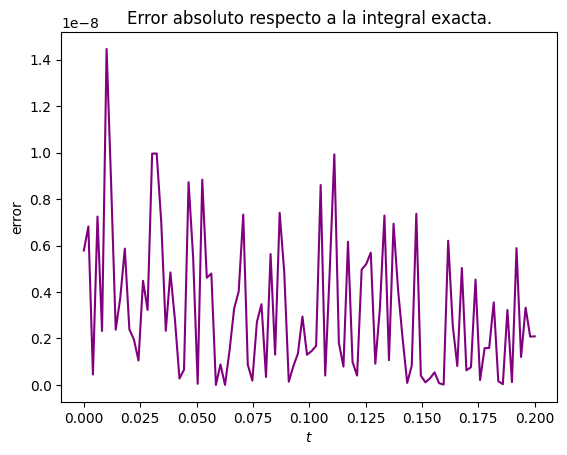

In [49]:
# Representación gráfica del error de cuadratura
fig, ax = plt.subplots()
ax.plot(tt,error_aprox_integr, color="purple")

# Instrucciones decorativas del gráfico.
ax.set_title("Error absoluto respecto a la integral exacta.")
ax.set_xlabel("$t$")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)
#ax.set_ylim(-1e-8,7.5e-6)

plt.show()                            # Se muestra el gráfico.